In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [2]:
n_qubits = 2
x_params = ParameterVector('x', length=n_qubits)
theta_params = ParameterVector('θ', length=n_qubits)

qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.ry(x_params[i], i)
for i in range(n_qubits):
    qc.ry(theta_params[i], i)
qc.cx(0, 1)

In [3]:
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=x_params,
    weight_params=theta_params,
    estimator=estimator
)

qnn_layer = TorchConnector(qnn)

In [4]:
class QAEModel(nn.Module):
    def __init__(self, latent_dim=1, output_dim=2):
        super(QAEModel, self).__init__()
        self.qnn = qnn_layer  # outputs shape [batch, 1]
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4),
            nn.ReLU(),
            nn.Linear(4, output_dim)
        )
    
    def forward(self, x):
        latent = self.qnn(x)
        return self.decoder(latent)

model_qae = QAEModel(latent_dim=1, output_dim=2)

In [5]:
def main():
    # Toy Dataset (2D Vectors)
    data = np.random.rand(100, 2)
    train_inputs = torch.tensor(data, dtype=torch.float32)
    train_targets = torch.tensor(data, dtype=torch.float32)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model_qae.parameters(), lr=0.01)
    loss_history = []
    num_epochs = 200

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model_qae(train_inputs)
        loss = loss_fn(outputs, train_targets)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training Loss for Quantum Autoencoder")
    plt.show()


    # Run inference (no gradient)
    with torch.no_grad():
        reconstructed = model_qae(train_inputs).numpy()

    # Convert original tensor to numpy
    original = train_inputs.numpy()

    # Plot original vs reconstructed in 2D
    plt.figure(figsize=(6, 6))
    plt.scatter(original[:, 0], original[:, 1], color='blue', label='Original', alpha=0.6)
    plt.scatter(reconstructed[:, 0], reconstructed[:, 1], color='red', label='Reconstructed', marker='x', alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("QAE: Original vs Reconstructed 2D Points")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()

    # Visualize Latent Encodings
    with torch.no_grad():
        latent = model_qae.qnn(train_inputs).numpy()

    plt.figure(figsize=(6, 3))
    plt.hist(latent, bins=30, color='purple', alpha=0.7)
    plt.title("Distribution of Latent Encodings (Quantum Output)")
    plt.xlabel("Latent Value")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


    with torch.no_grad():
        reconstructions = model_qae(train_inputs)

    # Calculate reconstruction error (mean squared error per sample)
    anomaly_scores = torch.mean((reconstructions - train_inputs) ** 2, dim=1)

    # Define a threshold, e.g., mean plus one standard deviation
    threshold = anomaly_scores.mean() + anomaly_scores.std()

    # Flag anomalies
    anomalies = anomaly_scores > threshold

    print("Threshold Score:", threshold)
    print("Anomaly Scores:", anomaly_scores)
    print("Anomalies flagged (True indicates an anomaly):", anomalies)

Epoch 0: Loss = 0.0400
Epoch 20: Loss = 0.0393
Epoch 40: Loss = 0.0392
Epoch 60: Loss = 0.0392
Epoch 80: Loss = 0.0392
Epoch 100: Loss = 0.0392
Epoch 120: Loss = 0.0392
Epoch 140: Loss = 0.0391
Epoch 160: Loss = 0.0391
Epoch 180: Loss = 0.0391


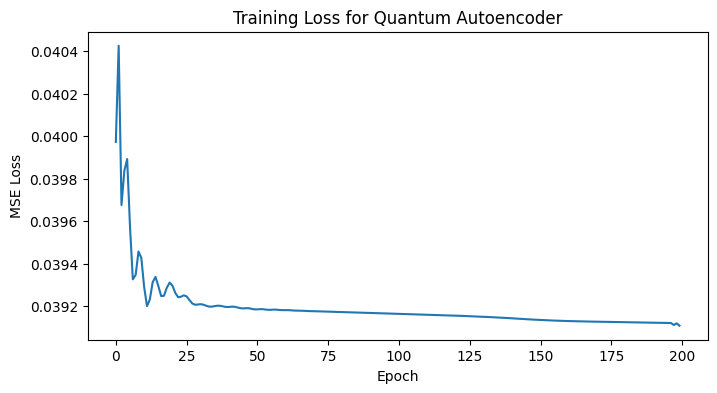

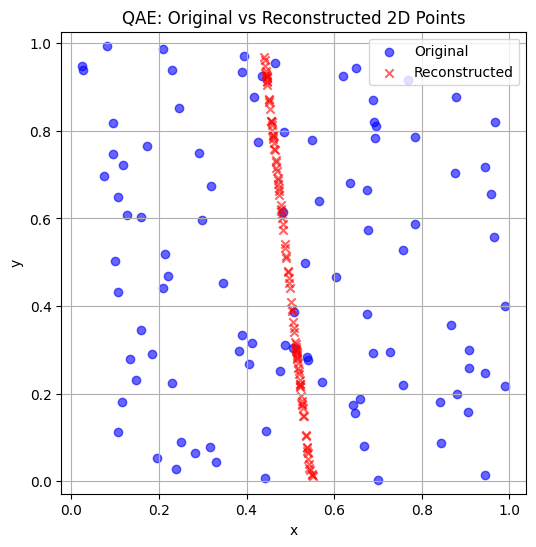

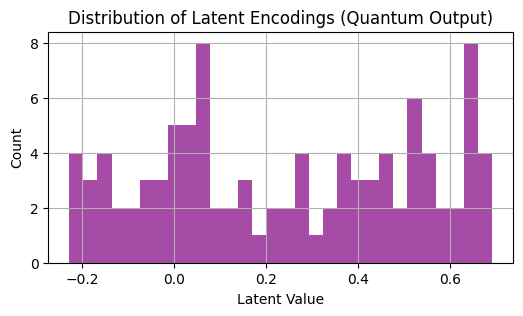

Threshold Score: tensor(0.0739)
Anomaly Scores: tensor([4.8962e-03, 3.9239e-03, 7.2430e-03, 1.4241e-03, 9.0912e-02, 7.5680e-02,
        6.7420e-02, 3.6615e-02, 3.7889e-04, 8.3474e-03, 6.1926e-03, 1.1126e-02,
        1.6692e-02, 5.0997e-02, 4.7238e-02, 1.5061e-02, 1.1740e-01, 1.2261e-03,
        3.0124e-04, 8.8283e-02, 6.6025e-03, 7.6392e-02, 4.2517e-02, 4.2190e-03,
        6.4993e-02, 7.2718e-02, 1.1418e-01, 2.7369e-02, 2.5425e-05, 1.5114e-04,
        1.3620e-02, 6.0948e-03, 2.7858e-02, 7.0246e-02, 3.3474e-02, 1.3099e-01,
        5.4646e-02, 6.7798e-02, 4.4459e-05, 1.1311e-02, 9.0127e-02, 5.8619e-03,
        1.1936e-01, 7.7868e-02, 2.3531e-02, 2.8174e-02, 2.7632e-02, 9.4641e-04,
        8.9613e-03, 2.1506e-02, 7.0817e-02, 6.2022e-02, 2.2809e-02, 4.1742e-02,
        8.8082e-02, 1.0361e-03, 3.6540e-04, 1.7429e-03, 6.6190e-04, 6.8248e-03,
        1.4927e-02, 4.6050e-02, 1.1891e-02, 2.2729e-02, 5.3003e-02, 4.6822e-02,
        4.9355e-02, 2.4948e-02, 2.8526e-04, 7.6680e-02, 1.4818e-02, 1.15

In [8]:
if __name__ == "__main__":
    main()

Epoch 0: Loss = 0.0846
Epoch 20: Loss = 0.0786
Epoch 40: Loss = 0.0626
Epoch 60: Loss = 0.0498
Epoch 80: Loss = 0.0498
Epoch 100: Loss = 0.0497
Epoch 120: Loss = 0.0496
Epoch 140: Loss = 0.0496
Epoch 160: Loss = 0.0496
Epoch 180: Loss = 0.0496


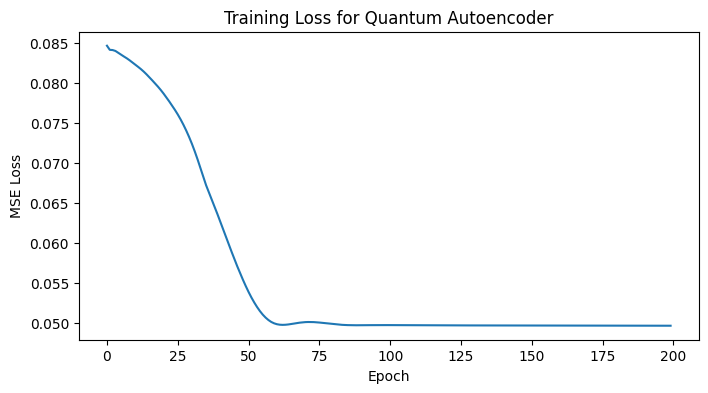

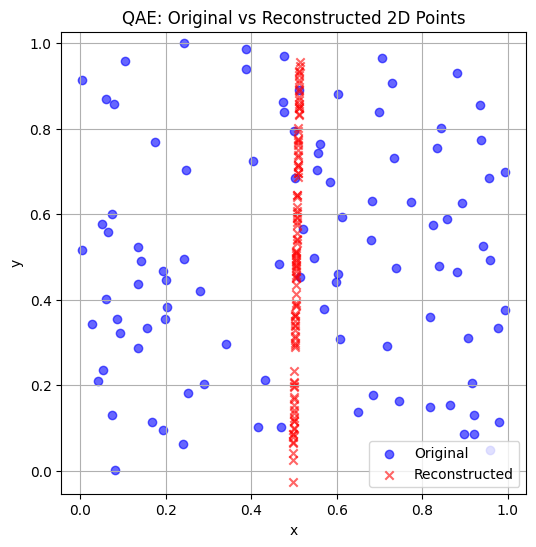

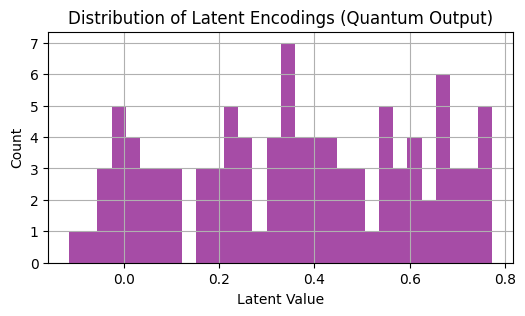

Threshold Score: tensor(0.0892)
Anomaly Scores: tensor([6.1967e-04, 1.7454e-02, 3.7429e-02, 1.4036e-04, 1.2008e-01, 5.0860e-02,
        5.5472e-02, 1.0064e-03, 3.0176e-02, 2.2393e-04, 1.3063e-02, 9.0729e-02,
        3.4383e-02, 9.4705e-02, 6.7986e-02, 8.6770e-02, 3.5589e-02, 5.0805e-02,
        8.4090e-02, 3.4108e-02, 2.2185e-02, 3.0500e-02, 8.7135e-03, 6.6139e-02,
        1.1511e-02, 5.2357e-02, 2.3826e-03, 1.0620e-01, 5.6961e-03, 1.0984e-03,
        8.2455e-03, 3.6082e-03, 5.6566e-04, 1.2544e-01, 1.0541e-01, 2.5312e-02,
        9.9577e-02, 9.8240e-02, 8.6930e-02, 9.3800e-02, 8.3118e-02, 2.5355e-02,
        4.4577e-03, 4.3300e-03, 1.1493e-01, 1.2853e-01, 8.6729e-02, 1.3635e-03,
        7.4192e-02, 1.5246e-02, 1.1284e-01, 8.1724e-02, 5.7522e-03, 4.7729e-03,
        1.0419e-01, 5.4479e-02, 8.9029e-02, 1.7091e-02, 2.9600e-03, 2.1933e-03,
        5.6379e-02, 2.7379e-02, 5.9709e-02, 9.1637e-02, 9.7198e-02, 5.4814e-03,
        6.9313e-02, 1.0169e-01, 1.5496e-02, 6.1718e-02, 1.1420e-03, 2.31

In [7]:
if __name__ == "__main__":
    main()

Epoch 0: Loss = 0.6360
Epoch 20: Loss = 0.2504
Epoch 40: Loss = 0.1468
Epoch 60: Loss = 0.1078
Epoch 80: Loss = 0.0936
Epoch 100: Loss = 0.0902
Epoch 120: Loss = 0.0894
Epoch 140: Loss = 0.0888
Epoch 160: Loss = 0.0882
Epoch 180: Loss = 0.0874


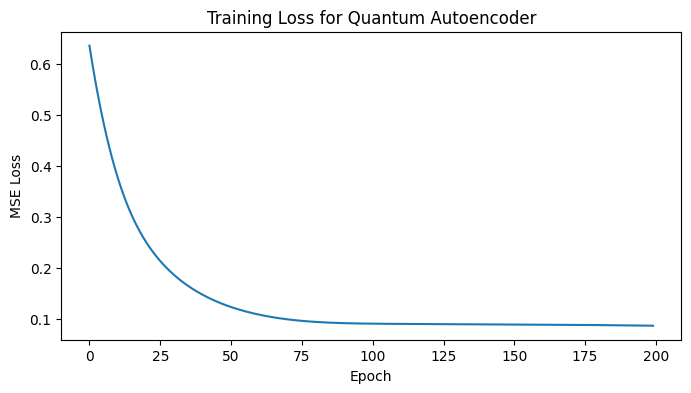

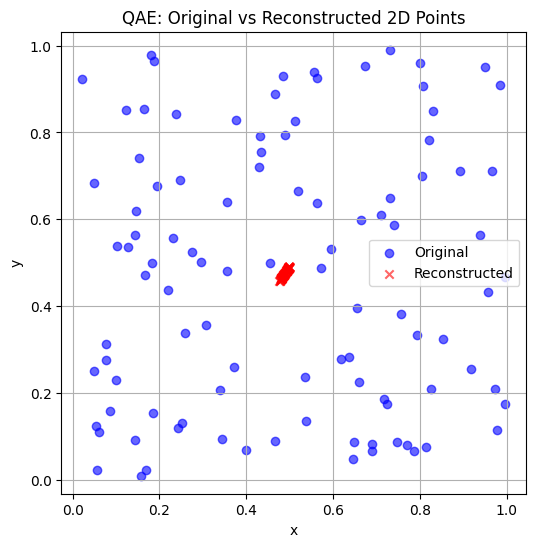

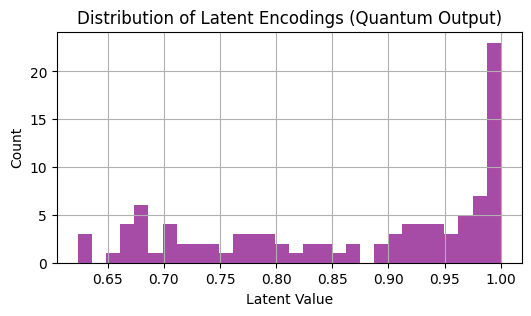

Threshold Score: tensor(0.1367)
Anomaly Scores: tensor([0.1151, 0.0563, 0.0805, 0.0966, 0.1425, 0.0219, 0.0198, 0.1840, 0.1027,
        0.2089, 0.1846, 0.0410, 0.1038, 0.0700, 0.0918, 0.1258, 0.0653, 0.1028,
        0.1197, 0.0062, 0.0649, 0.0808, 0.1349, 0.1168, 0.0850, 0.2054, 0.1195,
        0.0559, 0.1040, 0.0569, 0.1004, 0.0168, 0.0241, 0.1700, 0.0780, 0.0824,
        0.1222, 0.0361, 0.0697, 0.0009, 0.0276, 0.0721, 0.0519, 0.0484, 0.1203,
        0.0773, 0.1344, 0.0287, 0.0249, 0.1529, 0.0675, 0.1563, 0.0031, 0.1367,
        0.0094, 0.0943, 0.0161, 0.0452, 0.1265, 0.0372, 0.2077, 0.1095, 0.1506,
        0.0294, 0.0353, 0.1495, 0.1265, 0.1251, 0.0781, 0.0932, 0.0687, 0.0634,
        0.0400, 0.0881, 0.0953, 0.0988, 0.0974, 0.0973, 0.1311, 0.0483, 0.0308,
        0.1537, 0.0384, 0.0468, 0.0923, 0.0292, 0.1065, 0.0135, 0.1748, 0.0294,
        0.0208, 0.0706, 0.1514, 0.1616, 0.0972, 0.0455, 0.1227, 0.1011, 0.0375,
        0.0535])
Anomalies flagged (True indicates an anomaly): tensor([

In [6]:
if __name__ == "__main__":
    main()